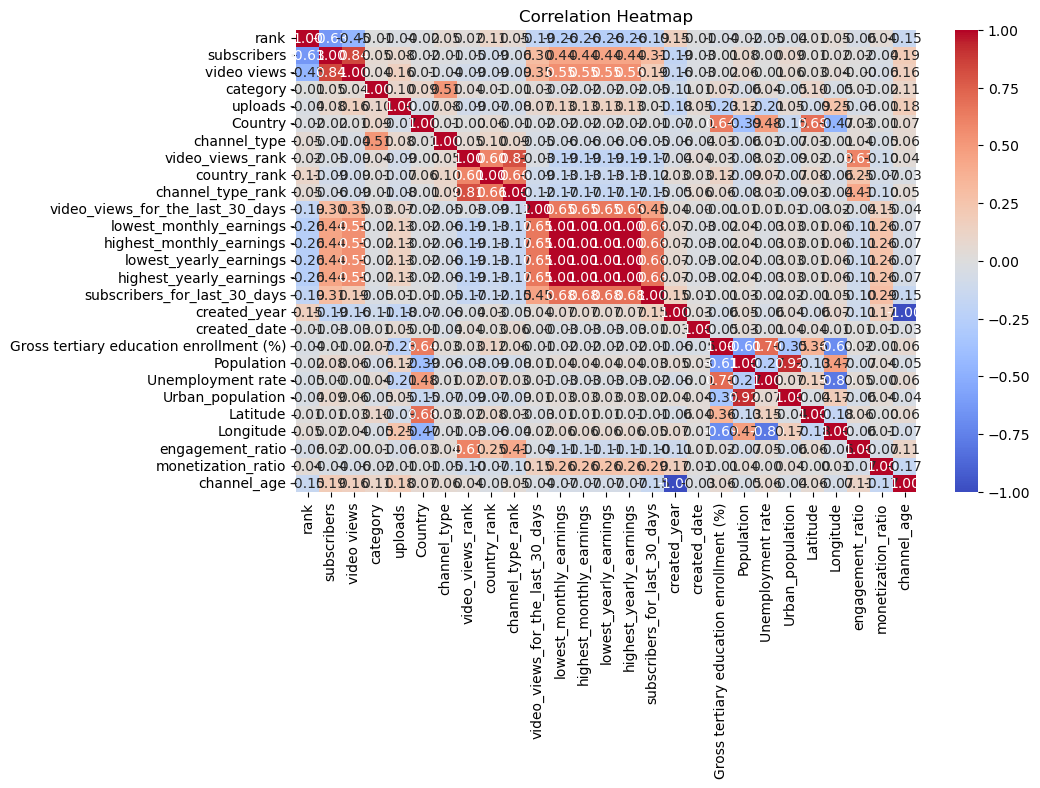

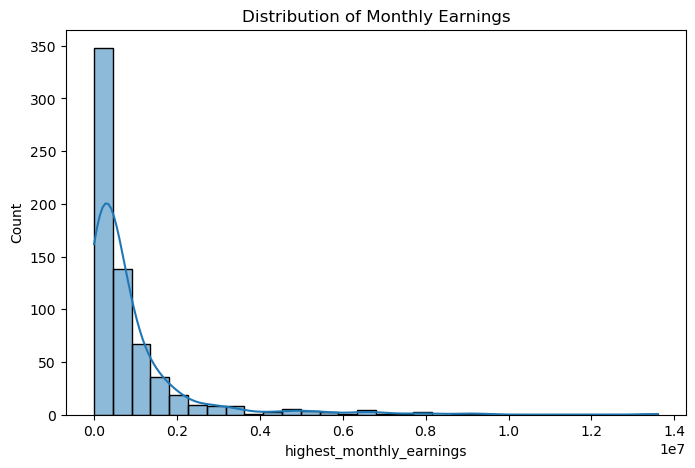

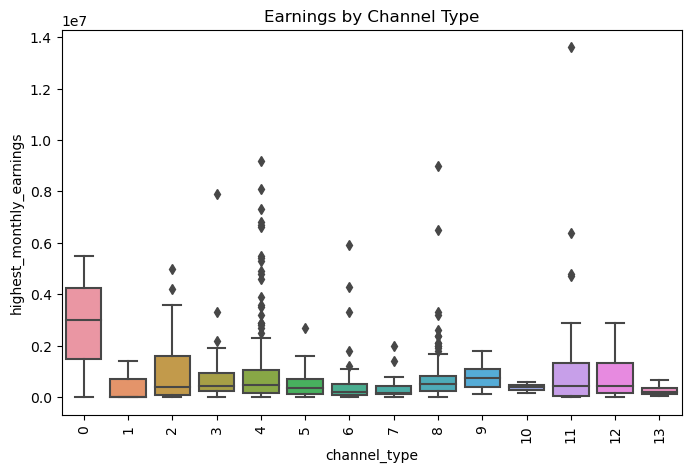


--- Revenue Prediction ---
MSE: 231036934313.21432
R2 Score: 0.8748738752821005

--- Channel Type Classification ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        37
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00        15
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00        30
           9       1.00      0.50      0.67         2
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3

    accuracy                           0.98       132
   macro avg       0.84      0.81      0.82       132
weighted avg    

C:\Users\nithi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\nithi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


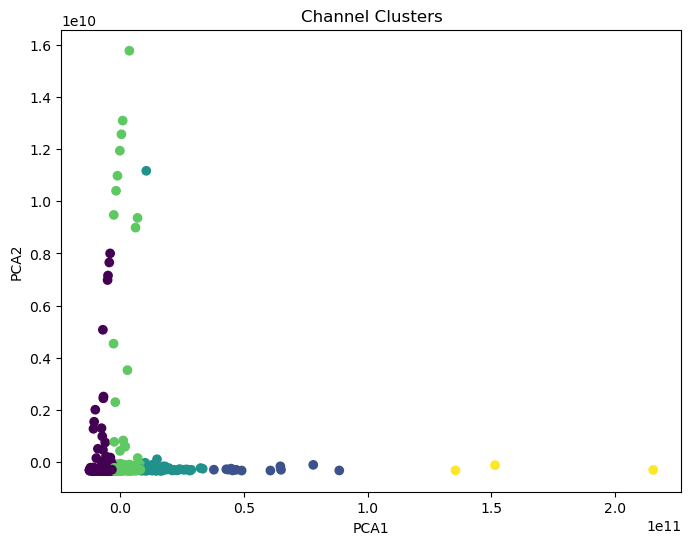

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Anomaly Detection ---
Anomalies Detected: 33 out of 658 channels


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.layers import Dense, Input
from keras.models import Model

# Load data
df=pd.read_csv("Global.csv",encoding='unicode_escape')
df

# Drop rows with missing target
df = df.dropna(subset=['subscribers_for_last_30_days'])

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Feature Engineering
df['engagement_ratio'] = df['video views'] / (df['uploads'] + 1)
df['monetization_ratio'] = df['highest_monthly_earnings'] / (df['video views'] + 1)
df['channel_age'] = 2025 - df['created_year']

# Encode categorical
le = LabelEncoder()
for col in ['category', 'channel_type', 'Country']:
    df[col] = le.fit_transform(df[col].astype(str))

# EDA
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['highest_monthly_earnings'], bins=30, kde=True)
plt.title("Distribution of Monthly Earnings")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='channel_type', y='highest_monthly_earnings', data=df)
plt.title("Earnings by Channel Type")
plt.xticks(rotation=90)
plt.show()

# Features and targets
features = ['video views', 'uploads', 'category', 'channel_type', 'Country',
            'engagement_ratio', 'monetization_ratio', 'channel_age', 'Population',
            'Unemployment rate', 'Urban_population']

X = df[features]
y_revenue = df['highest_monthly_earnings']
y_subs = df['subscribers_for_last_30_days']
y_class = df['channel_type']

# Train-test split
X_train, X_test, y_train_rev, y_test_rev = train_test_split(X, y_revenue, test_size=0.2, random_state=42)
X_train_subs, X_test_subs, y_train_subs, y_test_subs = train_test_split(X, y_subs, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_subs = scaler.fit_transform(X_train_subs)
X_test_subs = scaler.transform(X_test_subs)
X_scaled = scaler.fit_transform(X)

# ML Regression: XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train_rev)
y_pred_rev = xgb_model.predict(X_test)

print("\n--- Revenue Prediction ---")
print("MSE:", mean_squared_error(y_test_rev, y_pred_rev))
print("R2 Score:", r2_score(y_test_rev, y_pred_rev))

# ML Classification
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_class_train = scaler.fit_transform(X_class_train)
X_class_test = scaler.transform(X_class_test)

xgb_clf = XGBClassifier()
xgb_clf.fit(X_class_train, y_class_train)
y_pred_class = xgb_clf.predict(X_class_test)

print("\n--- Channel Type Classification ---")
print(classification_report(y_class_test, y_pred_class, zero_division=0))

# Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis')
plt.title("Channel Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Autoencoder for Anomaly Detection
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
thresh = np.percentile(mse, 95)
anomalies = mse > thresh
print("\n--- Anomaly Detection ---")
print(f"Anomalies Detected: {np.sum(anomalies)} out of {len(mse)} channels")
